In [30]:
run_directory = 'results/original_start_from_dataset/'

## Results including single runs

In [31]:
import json
import os
import pickle
from collections import defaultdict
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rcParams
from matplotlib.lines import Line2D
from rdkit import Chem
from rdkit.Chem import AllChem

from plot_utils import *
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import copy
import re 
from utils import *
params = {
    'font.size': 18,
    'legend.fontsize': 18,
    'text.usetex': False,
}
rcParams.update(params)

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [32]:
def compute_tolerance_intervals(trajectory, scores_1, scores_2, steps=[0, 30, 60, 90, 120, 150], n_samples=10):
    #print(trajectory)
    n_runs = trajectory.shape[0]
    n_steps = trajectory.shape[1]
    n_molecules = len(trajectory[0, 0])

    alternative_predictions = copy.deepcopy(trajectory)
    tolerance_intervals = []
    for step in steps:
        ti = []
        for run in range(n_runs):
            for molecule in range(len(trajectory[run, step])):
                if trajectory[run, step][molecule]:
                    index = np.argmin(np.abs(np.array(scores_1)-trajectory[run, step][molecule]))
                    ti.append(np.random.choice(a=scores_2[index]))
        tolerance_intervals.append(ti)    
    return tolerance_intervals, steps


def optimization_vs_control_even_ranges(scores_1, scores_2):
    score_max, score_min = max(scores_1), min(scores_1)
    counts = []
    n_steps = 25
    step = (score_max - score_min)/n_steps
    control_scores = []
    optimization_scores = []
    control_spread = []
    scores_1 = np.array(scores_1)
    scores_2 = np.array(scores_2)
    for i in range(n_steps):
        lower_bound = i*step
        upper_bound = (i+1)*step
        indexes_low = np.where(scores_1>=lower_bound)[0]
        indexes_up = np.where(scores_1<upper_bound)[0]
        indexes_step = []
        for j in range(len(scores_1)):
            if j in indexes_low and j in indexes_up:
                indexes_step.append(j)
        indexes_step = np.array(indexes_step)           
        counts.append(len(indexes_step))
        try:
            control_scores.append(np.mean(scores_2[indexes_step]))
        except:
            control_scores.append([0])

        try:
            #optimization_scores.append(np.mean(scores_1[indexes_step]))
            optimization_scores.append(upper_bound)
        except:
            optimization_scores.append(-1)

        try:
            #optimization_scores.append(np.mean(scores_1[indexes_step]))
            control_spread.append(scores_2[indexes_step])
        except:
            control_spread.append(control_spread[-1])
    return control_spread, control_scores, optimization_scores

def fit_clfs(chid, n_estimators=100, n_jobs=1, topliss_augmented=False, data_control=True, random_seed_0=0, 
             random_seed_1=0, min_samples_leaf=1, max_depth=None, return_training_set=False):
    """
    Args:
        chid: which assay to use:
        external_file:
    Returns:
        clfs: Dictionary of fitted classifiers
        aucs: Dictionary of AUCs
        balance: Two numbers showing the number of actives in split 1 / split 2
        df1: data in split 1
        df2: data in split 2
    """
    # read data and calculate ecfp fingerprints
    
    if chid=="ALDH1":
        assay_file = f'./assays/processed/210415_LIT_PCBA_ALDH1_Best_AB_sets.csv'
        df = pd.read_csv("210415_LIT_PCBA_ALDH1_Best_AB_sets.csv")
        df_train, df_test = train_test_split(df, test_size=0.1, random_state=random_seed_0)


        df1, df2 = train_test_split(df_train, test_size=0.5, random_state=random_seed_1)
        in_set_A = np.where(df['in_set_A']==1)[0]
        in_set_B = np.where(df['in_set_B']==1)[0]
        smiles = df["SMILES"]
        activity = df["Act"]
        index_test = []
        smiles_test = []
        smiles_train = []
        for i in range(len(smiles)):
            if i not in in_set_A and i not in in_set_B:
                index_test.append(i)
                smiles_test.append(smiles[i])
            if i in in_set_A:
                smiles_train.append(smiles[i])

        in_test = np.array(index_test)

        #in_test = np.where(df['in_set_A']==0 and df['in_set_B']==0)


        X1 = np.array(ecfp(smiles[in_set_A]))
        X2 = np.array(ecfp(smiles[in_set_B]))

        y1 = np.array(activity[in_set_A])
        y2 = np.array(activity[in_set_B])
        balance = (np.mean(y1), np.mean(y2))
    
    # train classifiers and store them in dictionary
        clfs = {}
        clfs['Split1'] = RandomForestClassifier(
            n_estimators=n_estimators, random_state=0)
        clfs['Split1'].fit(X1, y1)

        clfs['Split1_alt'] = RandomForestClassifier(
            n_estimators=n_estimators, random_state=1)
        clfs['Split1_alt'].fit(X1, y1)

        clfs['Split2'] = RandomForestClassifier(
            n_estimators=n_estimators, random_state=0)
        clfs['Split2'].fit(X2, y2)
        
    else:
        assay_file = f'./assays/processed/{chid}.csv'
        df = pd.read_csv(assay_file)

        df['ecfp'] = ecfp(df.smiles)
        df_train, df_test = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=random_seed_0)


        df1, df2 = train_test_split(df_train, test_size=0.5, stratify=df_train['label'], random_state=random_seed_1)
        X1 = np.array(list(df1['ecfp']))
        X2 = np.array(list(df2['ecfp']))

        y1 = np.array(list(df1['label']))
        y2 = np.array(list(df2['label']))

        del df1['ecfp']
        del df2['ecfp']
        smiles_test = list(df_test.smiles)
        smiles_train = list(df1.smiles)
        balance = (np.mean(y1), np.mean(y2))
    
    # train classifiers and store them in dictionary
        clfs = {}
        clfs['Split1'] = RandomForestClassifier(
            n_estimators=n_estimators, n_jobs=n_jobs, random_state=0, min_samples_leaf=min_samples_leaf, max_depth=max_depth)
        clfs['Split1'].fit(X1, y1)

        clfs['Split1_alt'] = RandomForestClassifier(
            n_estimators=n_estimators, n_jobs=n_jobs, random_state=1, min_samples_leaf=min_samples_leaf, max_depth=max_depth)
        clfs['Split1_alt'].fit(X1, y1)

        clfs['Split2'] = RandomForestClassifier(
            n_estimators=n_estimators, n_jobs=n_jobs, random_state=0, min_samples_leaf=min_samples_leaf, max_depth=max_depth)
        clfs['Split2'].fit(X2, y2)
    
    test_scores = clfs['Split1'].predict_proba(ecfp(smiles_test))[:, 1]
    if topliss_augmented:
        augmented_smiles_test = []
        for i, s in enumerate(smiles_test):
            if test_scores[i]>0.25:
                augmented_smiles_test.extend(topliss_walk(s, n_combinations=2))
            else:
                augmented_smiles_test.extend([s])
        augmented_smiles_test = np.array(augmented_smiles_test)
        X_test = ecfp(augmented_smiles_test)
    else:
        X_test = ecfp(smiles_test)

    scores_1 = clfs['Split1'].predict_proba(X_test)[:, 1]
    if data_control:
        scores_2 = clfs['Split2'].predict_proba(X_test)[:, 1]
    else:
        scores_2 = clfs['Split1_alt'].predict_proba(X_test)[:, 1]

    return scores_1, scores_2


In [33]:
def median_score_compound(pred, color=None, label=None, shade=False, alpha=.1, **kwargs):
    # pred is triply nested list [n_runs, n_epochs, n_mol(variable_size) ]
    # get mean scores over runs
    pred_mean = np.array([[np.mean([z for z in y if z is not None]) for y in x] for x in pred]).T
    median = np.median(pred_mean, 1)
    q25 = np.percentile(pred_mean, 25, axis=1)
    q75 = np.percentile(pred_mean, 75, axis=1)

    plt.plot(median, c=color, label=label, **kwargs)

    plt.fill_between(
        np.arange(median.shape[0]), q25, q75, alpha=alpha, color=color)
    
def median_score_single(pred, color=None, label=None, alpha=.1, **kwargs):
    medians = np.array([[np.median([t for t in y if t is not None]) for y in x] for x in pred])
    q25 = np.array([[np.percentile([t for t in y if t is not None], 25) for y in x] for x in pred])
    q75 = np.array([[np.percentile([t for t in y if t is not None], 75) for y in x] for x in pred])
    n_runs = medians.shape[0]
    for i in range(n_runs):
        plt.plot(medians[i], c=color, label=label, **kwargs)
        label = None  # avoid multiple legend entries
        plt.fill_between(
            np.arange(medians[i].shape[0]), q25[i], q75[i], alpha=alpha, color=color)

def plot_wrapper(preds_internal, primitive, name, col_dict, legend_dict, ls_dict, alpha_dict, skip=[], xlabel=None, ylabel=None, ax=None, legend=True, leg_lw=3, **kwargs):
    if ax is not None:
        plt.sca(ax)
    for k, pred in preds_internal.items():
        if k in skip:
            continue
        primitive(
            pred, color=col_dict[k], label=legend_dict[k], ls=ls_dict[k], alpha=alpha_dict[k], **kwargs)

    if legend:
        leg = plt.legend(loc='upper center', bbox_to_anchor=(
            0.5, 1.14), ncol=3, frameon=False)
        for line in leg.get_lines():
            line.set_linewidth(leg_lw)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [34]:
results_dir = Path(run_directory)
figure_dir = Path('figures')
os.makedirs(figure_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

write = False
columns = ['AssayID', 'TargetName', 'TargetID']
rows = [('CHEMBL3888429', 'JAK2', 'CHEMBL2971'),
        ('CHEMBL1909203', 'EGFR', 'CHEMBL203'),
        ('CHEMBL1909140', 'DRD2', 'CHEMBL217'),
        ('CHEMBL1794345', 'Pla. Fal.', 'CHEMBL364'),
        ('CHEMBL1741322', 'Cytochrome', 'CHEMBL3356'),
        ('CHEMBL1963961', 'CCRF-CEM', 'CHEMBL382')]
assay_info = pd.DataFrame(rows, columns=columns)
# display(assay_info)

# dictionary to convert chemblID to readable name
chid2name = dict(zip(assay_info['AssayID'], assay_info['TargetName']))

# The predictions for OS, MCS and DCS are saved in dictionaries with these keys
# These dictionaries map these identifiers to more readable strings, colors/linestyles used in plots
order = ('Split1', 'Split1_alt', 'Split2')
legend_dict = dict(zip(order, [r'$S_{opt}$', r'$S_{mc}$', r'$S_{dc}$']))
opt_dict = {'graph_ga': 'Graph GA', 'lstm_hc': 'LSTM', 'mso': 'MSO'}
col_dict = dict(zip(order, ['blue', 'green', 'red']))
col_dict2 = dict(zip(order, ['cyan', 'magenta', 'green']))
ls_dict = dict(zip(order, ['-', '--', '-.']))

# get chembl identifiers used in experiments
# go one step down in tree to get the name of some optimizer ('graph_ga' or 'lstm_hc')
chids = sorted(os.listdir(run_directory + 'graph_ga'))

# get some stats on these assays
assay_stats = []
for chid in chids:
    row = {}
    assay_data = pd.read_csv(f'./assays/processed/{chid}.csv')
    label = assay_data['label']
    
    row['active'] = label.sum()
    row['inactive'] = len(label) - row['active']
    row['size'] = len(label)
    row['AssayID'] = chid
    assay_stats.append(row)


# get mean and std of all the classifiers trained for dataset
optimizers = sorted([o.name for o in results_dir.iterdir() if o.is_dir()])

# Averaged runs analysis

/opt/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when

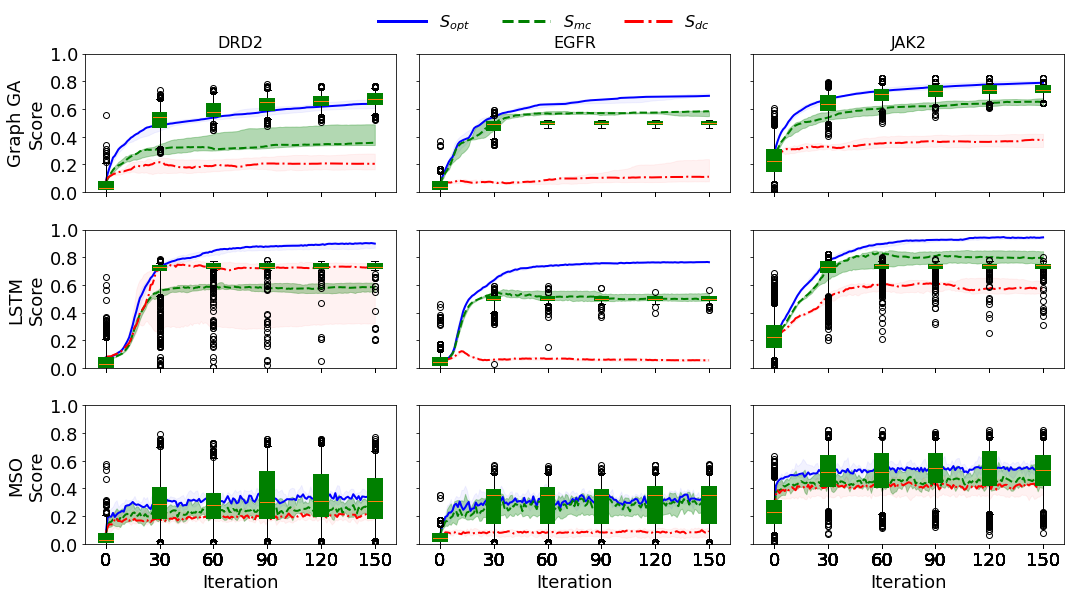

In [35]:
#chids = ['CHEMBL1909140', 'CHEMBL1909140']
#optimizers = ['graph_ga', 'lstm_hc']
auc_title = False # whether or not to include auc in plot
lw = 2
nrows = 3 # for two optimizers
ncols = len(chids)
optimizers = ['graph_ga', 'lstm_hc', 'mso']

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 2.75*nrows), sharex=True, sharey=True)
for r_idx, optimizer in enumerate(optimizers):
    for c_idx, chid in enumerate(chids):
        ax = axes[r_idx][c_idx]
        assay_file ='assays/processed/' + str(chid) + '.csv'
        df = pd.read_csv(assay_file)
         
        preds_internal, preds_external, auc, _, _  = load_chid(
            results_dir/optimizer/chid, order)
        scores_1, scores_2 = fit_clfs(chid, topliss_augmented=True, data_control=False)
        control_spread, control_scores, optimization_scores = optimization_vs_control_even_ranges(scores_1, scores_2)
        tolerance_intervals, steps = compute_tolerance_intervals(np.array(preds_internal['Split1']), optimization_scores, control_spread, n_samples=100)
        alpha_dict = dict(zip(order, [0.05, 0.3, 0.05]))

        plot_wrapper(preds_internal, median_score_compound, name='median_score_compound', col_dict=col_dict, legend_dict=legend_dict, ls_dict=ls_dict, ax=ax, legend=False, lw=lw, alpha_dict=alpha_dict)
        bp0 = ax.boxplot(tolerance_intervals, positions=steps, widths=7.5, whis = [2.5, 97.5], patch_artist=True)
        for box in bp0['boxes']:
            box.set(color='green', linewidth=2)
        # makes ticks a bit prettier and always makes them at multiples of 0.2
        ax.set_ylim(0, 1)
        low, high = 0, 1
        step = (high-low)/5
        yticks = np.arange(round(low/0.2) * 0.2, round(high/0.2) * 0.2 +0.01, 0.2)
        ax.set_yticks(yticks)

# set axes labels 
for i in range(nrows):
    axes[i][0].set_ylabel('Score')
    
for i in range(ncols):
    axes[-1][i].set_xlabel('Iteration')

# set titles to denote tasks
for i, chid in enumerate(chids):
    title = chid2name.get(chid, chid)
    if auc_title:
        title += f' ({aucs[chid][0]:.2f})'
    axes[0][i].set_title(title, fontsize=16)

# create legend
custom_lines = [Line2D([0], [0], color=col_dict[k], lw=3, ls=ls_dict[k]) for k in col_dict.keys()]
lgd = fig.legend(custom_lines, list(legend_dict.values()), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.03), frameon=False, fontsize=16,handlelength=3)

# add optimizer info by adding text
text_fields = []
xtext = -55

for i, optimizer in enumerate(optimizers):
    txt = axes[i][0].text(xtext, sum(axes[i][0].get_ylim()) /2 , opt_dict[optimizer], rotation=90, verticalalignment='center')
    text_fields.append(txt)
    
fig.tight_layout()
plt.savefig('figures/median_scores_start_dataset_model_control.pdf', bbox_inches='tight')

/opt/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when

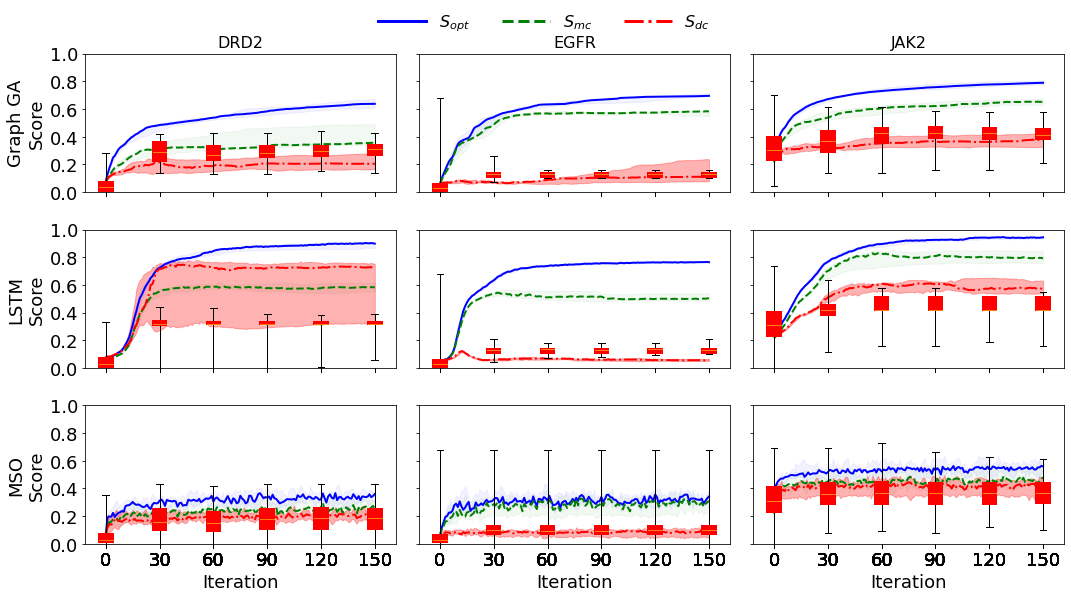

In [36]:
nrows = 3 # for two optimizers
ncols = len(chids)
optimizers = ['graph_ga', 'lstm_hc', 'mso']

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 2.75*nrows), sharex=True, sharey=True)
for r_idx, optimizer in enumerate(optimizers):
    for c_idx, chid in enumerate(chids):
        ax = axes[r_idx][c_idx]
        preds_internal, preds_external, auc, _,_  = load_chid(
            results_dir/optimizer/chid, order)
        assay_file ='assays/processed/' + str(chid) + '.csv'
        df = pd.read_csv(assay_file)
         
        preds_internal, preds_external, auc, _,_   = load_chid(
            results_dir/optimizer/chid, order)
        scores_1, scores_2 = fit_clfs(chid, topliss_augmented=True, data_control=True)
        control_spread, control_scores, optimization_scores = optimization_vs_control_even_ranges(scores_1, scores_2)
        tolerance_intervals, steps = compute_tolerance_intervals(np.array(preds_internal['Split1']), optimization_scores, control_spread, n_samples=100)
        alpha_dict = dict(zip(order, [0.05, 0.05, 0.3]))

        plot_wrapper(preds_internal, median_score_compound, name='median_score_compound', col_dict=col_dict, legend_dict=legend_dict, ls_dict=ls_dict, ax=ax, legend=False, lw=lw, alpha_dict=alpha_dict)
     
        bp0 = ax.boxplot(tolerance_intervals, positions=steps, widths=7.5, whis = [0, 100], patch_artist=True)
        for box in bp0['boxes']:
            box.set(color='red', linewidth=2)
        # makes ticks a bit prettier and always makes them at multiples of 0.2
        ax.set_ylim(0, 1)
        low, high = 0, 1
        step = (high-low)/5
        yticks = np.arange(round(low/0.2) * 0.2, round(high/0.2) * 0.2 +0.01, 0.2)
        ax.set_yticks(yticks)

# set axes labels 
for i in range(nrows):
    axes[i][0].set_ylabel('Score')
    
for i in range(ncols):
    axes[-1][i].set_xlabel('Iteration')

# set titles to denote tasks
for i, chid in enumerate(chids):
    title = chid2name.get(chid, chid)
    if auc_title:
        title += f' ({aucs[chid][0]:.2f})'
    axes[0][i].set_title(title, fontsize=16)

# create legend
custom_lines = [Line2D([0], [0], color=col_dict[k], lw=3, ls=ls_dict[k]) for k in col_dict.keys()]
lgd = fig.legend(custom_lines, list(legend_dict.values()), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.03), frameon=False, fontsize=16,handlelength=3)

# add optimizer info by adding text
text_fields = []
xtext = -55

for i, optimizer in enumerate(optimizers):
    txt = axes[i][0].text(xtext, sum(axes[i][0].get_ylim()) /2 , opt_dict[optimizer], rotation=90, verticalalignment='center')
    text_fields.append(txt)
    
fig.tight_layout()
plt.savefig('figures/median_scores_start_dataset_data_control.pdf', bbox_inches='tight')